In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,BatchNormalization
from keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD,RMSprop
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

from keras.models import Sequential
warnings.filterwarnings('ignore')

from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Dropout

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.utils import plot_model

def display_images(desired_shape, images, num_images=6):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].reshape(desired_shape[0], desired_shape[1]), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def process_pixel_data(pixel_data, desired_shape):
    return np.array([np.array([float(x) for x in item.split()]).reshape(desired_shape) for item in pixel_data])

def process_labels(labels):
    # Convert labels to numerical format if they're not numeric
    unique_labels = {label: idx for idx, label in enumerate(np.unique(labels))}
    return np.array([unique_labels[label] for label in labels]), unique_labels

def make_model(pixel_data, labels):
    # Process pixel data
    input_shape = (128, 128, 1) # Corresponds to target_size in preprocess.py, but with an added dimension
    processed_images = process_pixel_data(pixel_data, desired_shape=input_shape)

    display_images(input_shape, processed_images)

    # Process labels
    processed_labels, label_map = process_labels(labels)
    processed_labels = to_categorical(processed_labels)

    # Splitting data into training and testing sets
    train_img, test_img, train_cancer_cat, test_cancer_cat = train_test_split(
    processed_images, processed_labels, test_size=0.2, random_state=42, stratify=None)

    lambda_val = 0.01
    epochs = 20
    
    # CNN Model
    model = Sequential([
        Conv2D(256, (3,3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(lambda_val)),
        MaxPool2D(2,2),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(lambda_val)),
        MaxPool2D(2,2),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(lambda_val)),
        MaxPool2D(2,2),
        BatchNormalization(),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(lambda_val)),
        Dense(64, activation='relu', kernel_regularizer=l2(lambda_val)),
        Dense(len(label_map), activation='softmax') 
    ])

    plot_model(model, to_file='cnn_h.png', show_shapes=True, show_layer_names=True, rankdir="LR")

    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_img, train_cancer_cat, validation_data=(test_img, test_cancer_cat), epochs=epochs)

    # Evaluation and reporting
    print("Training Accuracy:", history.history['accuracy'][-1])
    print("Validation Accuracy:", history.history['val_accuracy'][-1])

    # Evaluation
    print("Training accuracies:")
    print(history.history["accuracy"][-1])

    # MLP Model
    mlp_model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(label_map), activation='softmax')
    ])

    plot_model(mlp_model, to_file='mlp_h.png', show_shapes=True, show_layer_names=True, rankdir="LR")

    mlp_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    mlp_history = mlp_model.fit(
        train_img, train_cancer_cat,
        validation_data=(test_img, test_cancer_cat),
        epochs=epochs
    )

    # Evaluation and reporting
    print("Training Accuracy:", mlp_history.history['accuracy'][-1])
    print("Validation Accuracy:", mlp_history.history['val_accuracy'][-1])

    # Evaluation
    print("Training accuracies:")
    print(mlp_history.history["accuracy"][-1])


In [ ]:
import os
import subprocess
!find . -name ".DS_Store" -delete

# TODO: Need to make a for-loop that goes through every folder in images and annotations. This is 
# because the way the code works, it only goes through one folder at a time, so we need a loop
# that calls big_helper.py multiple times. I don't care about runtime anymore...

# NOTE: There will be Not-Found errors because not all the image files are downloaded even though all
# the annotations are downloaded.

# # Some of the stencil code uses depricated code, but it is still needed
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

# This code block basically preprocesses the image data and puts it into a CSV file
for folder in os.listdir("dl_data/annotations"):
    dicom_path = f"dl_data/images/Lung_Dx-{folder}"
    annotation_path = f"dl_data/annotations/{folder}" 

    # # Initial folder_list below
    # folder_list = ['A0001', 'A0002', 'A0003', 'A0004', 'A0005', 'B0004', 'B0005', 'E0001', 'E0002', 'G0004', 'G0005']
    
    # # Full folder_list below
    # folder_list = ['A0001', 'A0002', 'A0003', 'A0004', 'A0005', 'A0202', 'B0004', 'B0005', 'B0011', 'B0012'
    #                , 'B0013', 'B0014', 'B0015', 'B0016', 'B0017', 'B0018', 'B0019', 'B0020', 'B0021', 'B0022'
    #                 , 'B0023', 'B0024', 'B0025', 'E0001', 'E0002', 'E0003', 'E0004', 'E0005', 'G0004', 'G0005'
    #                 , 'G0010', 'G0011', 'G0012', 'G0013', 'G0014', 'G0015', 'G0016', 'G0017', 'G0018', 'G0019'
    #                 , 'G0020']

    # ~600mb folder_list
    folder_list = ['A0001', 'A0002', 'A0003', 'A0004', 'A0005', 'B0004', 'B0005', 'B0011', 'B0012'
                   'E0001', 'E0002', 'E0003', 'E0004', 'G0004', 'G0005'
                    , 'G0010', 'G0011', 'G0012']
    
    if folder not in folder_list:
        continue
    else:
        print(folder)
    
    command = [
        "python", "preprocess.py", "--dicom-mode", "CT",
        "--dicom-path", dicom_path,
        "--annotation-path", annotation_path,
        "--classfile", "category.txt"
    ]
    
    # Execute the command
    subprocess.run(command)

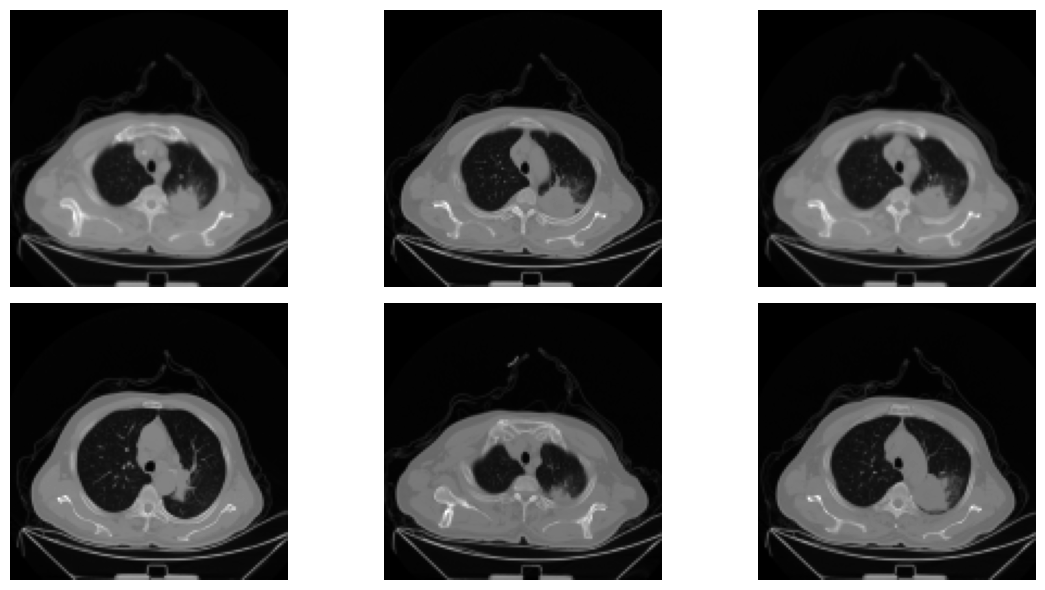

Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 10.3937 - accuracy: 0.4057WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x28c62e320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


8/8 [==============================] - 21s 2s/step - loss: 10.3937 - accuracy: 0.4057 - val_loss: 256.8730 - val_accuracy: 0.2295
Epoch 2/20
8/8 [==============================] - 13s 2s/step - loss: 7.6399 - accuracy: 0.9303 - val_loss: 159.6841 - val_accuracy: 0.2295
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 7.2629 - accuracy: 0.9918 - val_loss: 68.0143 - val_accuracy: 0.2295
Epoch 4/20
8/8 [==============================] - 14s 2s/step - loss: 6.9248 - accuracy: 1.0000 - val_loss: 42.3081 - val_accuracy: 0.2295
Epoch 5/20
8/8 [==============================] - 14s 2s/step - loss: 6.5800 - accuracy: 1.0000 - val_loss: 24.9961 - val_accuracy: 0.2951
Epoch 6/20
8/8 [==============================] - 14s 2s/step - loss: 6.2160 - accuracy: 1.0000 - val_loss: 15.5638 - val_accuracy: 0.3934
Epoch 7/20
8/8 [==============================] - 15s 2s/step - loss: 5.8553 - accuracy: 1.0000 - val_loss: 10.7783 - val_accuracy: 0.5574
Epoch 8/20
8/8 [===================

Epoch 1/20
8/8 [==============================] - 1s 36ms/step - loss: 1.5636 - accuracy: 0.5123 - val_loss: 0.7037 - val_accuracy: 0.8197
Epoch 2/20
8/8 [==============================] - 0s 19ms/step - loss: 0.8376 - accuracy: 0.7459 - val_loss: 0.3721 - val_accuracy: 0.8197
Epoch 3/20
8/8 [==============================] - 0s 22ms/step - loss: 0.6616 - accuracy: 0.7787 - val_loss: 0.6869 - val_accuracy: 0.7541
Epoch 4/20
8/8 [==============================] - 0s 22ms/step - loss: 0.4190 - accuracy: 0.8566 - val_loss: 0.4722 - val_accuracy: 0.8689
Epoch 5/20
8/8 [==============================] - 0s 20ms/step - loss: 0.3393 - accuracy: 0.8975 - val_loss: 0.6332 - val_accuracy: 0.8033
Epoch 6/20
8/8 [==============================] - 0s 19ms/step - loss: 0.2205 - accuracy: 0.9344 - val_loss: 0.2994 - val_accuracy: 0.9180
Epoch 7/20
8/8 [==============================] - 0s 20ms/step - loss: 0.1862 - accuracy: 0.9467 - val_loss: 0.2035 - val_accuracy: 0.9180
Epoch 8/20
8/8 [===========

In [12]:
data = pd.read_csv('output.csv')
make_model(data['pixel_data'], data['cancer_type'])